In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
from matplotlib import rcParams
import scanpy as sc
import random
import FlowCal
import warnings
from sklearn import model_selection, neighbors, linear_model
import glob
import csv
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from scipy.stats import spearmanr, pearsonr
import plotly.graph_objects as go
from IPython.display import Image
warnings.filterwarnings("ignore")

#### Read in CSV file(data)

In [2]:
ICU_patients_datas = []
ICU_patients_datas_validation = []
non_ICU_patients_datas = []
non_ICU_patients_datas_validation = []
recovered_patients_datas = []
recovered_patients_datas_validation = []

with open('ICU_patients_datas.csv', mode ='r')as file: 
    csvFile = csv.reader(file)
    for line in csvFile:
        ICU_patients_datas.append(line)
ICU_patients_datas = np.array(ICU_patients_datas)

with open('ICU_patients_datas_validation.csv', mode ='r')as file: 
    csvFile = csv.reader(file)
    for line in csvFile:
        ICU_patients_datas_validation.append(line)
ICU_patients_datas_validation = np.array(ICU_patients_datas_validation)

with open('non_ICU_patients_datas.csv', mode ='r')as file: 
    csvFile = csv.reader(file)
    for line in csvFile:
        non_ICU_patients_datas.append(line)
non_ICU_patients_datas = np.array(non_ICU_patients_datas)

with open('non_ICU_patients_datas_validation.csv', mode ='r')as file: 
    csvFile = csv.reader(file)
    for line in csvFile:
        non_ICU_patients_datas_validation.append(line)
non_ICU_patients_datas_validation = np.array(non_ICU_patients_datas_validation)

with open('recovered_patients_datas.csv', mode ='r')as file: 
    csvFile = csv.reader(file)
    for line in csvFile:
        recovered_patients_datas.append(line)
recovered_patients_datas = np.array(recovered_patients_datas)

with open('recovered_patients_datas_validation.csv', mode ='r')as file: 
    csvFile = csv.reader(file)
    for line in csvFile:
        recovered_patients_datas_validation.append(line)
recovered_patients_datas_validation = np.array(recovered_patients_datas_validation)

#### Get cell name array

In [2]:
results_file = 'COV-26_20200414_d_A1.fcs'
adata = FlowCal.io.FCSData(results_file)
cell_names = np.array(adata.channels[2:-4])
print(cell_names)

['Y89Di' 'Pd102Di' 'Pd104Di' 'Pd105Di' 'Pd106Di' 'Pd108Di' 'Cd110Di'
 'Cd111Di' 'Cd112Di' 'Cd113Di' 'Cd114Di' 'In115Di' 'Cd116Di' 'Xe131Di'
 'Cs133Di' 'Ce140Di' 'Pr141Di' 'Nd142Di' 'Nd143Di' 'Nd144Di' 'Nd145Di'
 'Nd146Di' 'Sm147Di' 'Nd148Di' 'Sm149Di' 'Nd150Di' 'Eu151Di' 'Sm152Di'
 'Eu153Di' 'Gd154Di' 'Gd155Di' 'Gd156Di' 'Gd157Di' 'Gd158Di' 'Tb159Di'
 'Gd160Di' 'Dy161Di' 'Dy162Di' 'Dy163Di' 'Dy164Di' 'Ho165Di' 'Er166Di'
 'Er167Di' 'Er168Di' 'Tm169Di' 'Er170Di' 'Yb171Di' 'Yb172Di' 'Yb173Di'
 'Yb174Di' 'Lu175Di' 'Yb176Di' 'Ir191Di' 'Ir193Di' 'Pt194Di' 'Pt195Di'
 'Pt196Di' 'Pt198Di' 'Bi209Di']


#### Make marker-cell dictionary

In [4]:
marker_cell_dict = {}
CD_marker_to_cell = {}

with open('marker names.csv', mode ='r')as file: 
    csvFile = csv.reader(file)
    for line in csvFile:
        marker_cell_dict[line[0]] = line[1]

with open('CD markers to cell names.csv', mode ='r')as file: 
    csvFile = csv.reader(file)
    for line in csvFile:
        CD_marker_to_cell[line[0]] = line[1]

for cell_name in cell_names:
    if (not cell_name in marker_cell_dict):
        marker_cell_dict[cell_name] = "Null"

CD_marker_to_cell["Null"] = "Unknown"

#### Get training set database and label

In [5]:
database = []
label = []
for patient in ICU_patients_datas:
    database.append(patient)
for patient in non_ICU_patients_datas:
    database.append(patient)
for patient in recovered_patients_datas:
    database.append(patient)
    
for i in range(0, ICU_patients_datas.shape[0]):
    label.append('ICU')
for i in range(0, non_ICU_patients_datas.shape[0]):
    label.append('non-ICU')
for i in range(0, recovered_patients_datas.shape[0]):
    label.append('recovered')
    
database = np.array(database)
label = np.array(label)

#### First, optimize n_neighbor with no feature selection

#### Use 6 folds so that each test set contains at least 1 non-ICU patient

In [6]:
# Convert string label to int label
label_int = []
for i in range(0, ICU_patients_datas.shape[0]):
    label_int.append(0) # "ICU" = 0
for i in range(0, non_ICU_patients_datas.shape[0]):
    label_int.append(1) # "non-ICU" = 1
for i in range(0, recovered_patients_datas.shape[0]):
    label_int.append(2) # recovered" = 2

#### Then do a demension reduction(LASSO)

In [7]:
lasso = linear_model.Lasso(alpha=0.2, fit_intercept = True, normalize = False).fit(database, label_int)
model_lasso = SelectFromModel(lasso, prefit=True)
lasso_new = model_lasso.transform(database)
print("Before feature selection: " + str(database.shape[1]) + " features")
print("After feature selection: " + str(lasso_new.shape[1]) + " features")

Before feature selection: 59 features
After feature selection: 41 features


#### Get the ranking of the affect coefficients(absolute value) for LASSO

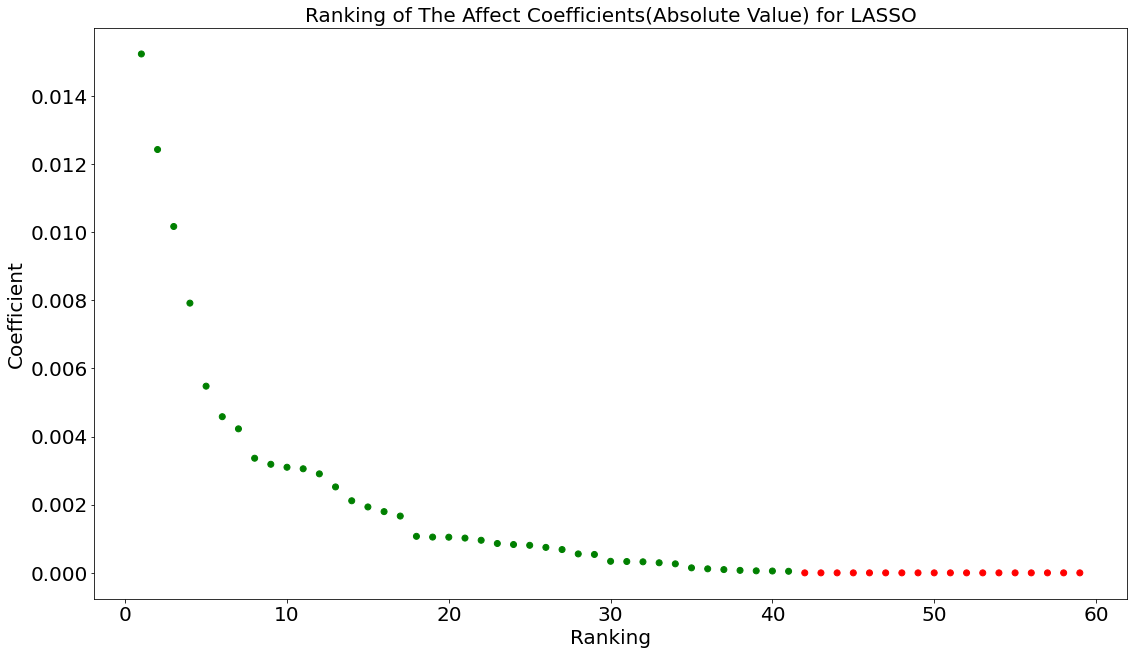

The ranking of the affect coefficients(absolute value) for LASSO is:
1. Dy164Di(CCR3: Unknown): 0.015233592969199728
2. Eu153Di(CD1c: T Cell/ B Cell/ Dendritic Cell/ Macrophage): 0.012428325056657002
3. Er167Di(Er167Di: Unknown): 0.010168488795962782
4. Tm169Di(PPARg: Unknown): 0.007918847246251384
5. Cd112Di(Null: Unknown): 0.005481036427697278
6. Cd114Di(Null: Unknown): 0.004584842597260115
7. Yb171Di(CD68: T Cell/ B Cell/ Dendritic Cell/ Stem Cell/ Macrophage/ Granulocyte): 0.004228224714328943
8. Nd150Di(Nd150Di: Unknown): 0.003365346329934662
9. Gd160Di(CD14: Macrophage/ Granulocyte): 0.003187463762232228
10. Pt198Di(Null: Unknown): 0.0031005642839893755
11. Lu175Di(PD-L1: Unknown): 0.0030557684177636843
12. Nd144Di(CD141: Macrophage/ Granulocyte/ Platelet/ Endothelial Cell/ Epithelial Cell): 0.0029064576132497378
13. Er166Di(CD24: B Cell/ Granulocyte/ Epithelial Cell): 0.002522947942133873
14. Gd155Di(Gd155Di: Unknown): 0.0021164819411685857
15. Sm147Di(Gata6: Unknown): 0.0019350

In [8]:
lasso_dict = {}
name = []
coef = []
for i in range(0, cell_names.shape[0]): 
    lasso_dict[cell_names[i]] = abs(lasso.coef_[i])
affect_coef = sorted(lasso_dict.items(), key = lambda kv:(kv[1], kv[0]), reverse = True)
for i in range(0, len(affect_coef)):
    if (affect_coef[i][1] != 0):
        name.append(affect_coef[i][0] + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")")
        coef.append(affect_coef[i][1])
    else:
        name.append(affect_coef[i][0] + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")" + "(0 coef)")
        coef.append(affect_coef[i][1])

# Plot the Ranking
x_label = np.arange(1, 60, 1)
color = []
for i in range(0, len(coef)):
    if (coef[i] != 0):
        color.append('green')
    else:
        color.append('red')
fig, axs = plt.subplots(1, sharex=True, sharey=False)
fig.set_size_inches(18.5, 10.5)
axs.scatter(x_label, coef, color = color)
plt.title("Ranking of The Affect Coefficients(Absolute Value) for LASSO", fontsize = 20)
plt.ylabel('Coefficient', size = 20)
plt.xlabel('Ranking', size = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

# List detailed numbers and cell names
print("The ranking of the affect coefficients(absolute value) for LASSO is:")
zero_position = 0
for i in range(0, len(affect_coef)):
    if (affect_coef[i][1] != 0):
        print(str(i + 1) + ". " + str(affect_coef[i][0]) + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")" + ": " + str(affect_coef[i][1]))
    else:
        if (affect_coef[i - 1][1] != 0):
            zero_position = i + 1
            print(str(i + 1) + ". " + str(affect_coef[i][0]) + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")" + ": " + str(affect_coef[i][1]))
        else:
            print(str(zero_position) + ". " + str(affect_coef[i][0]) + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")" + ": " + str(affect_coef[i][1]))

#### do another demension reduction(LinearSVC)

In [12]:
svc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(database, label_int)
model_svc = SelectFromModel(svc, prefit=True)
svc_new = model_svc.transform(database)
print("Before feature selection: " + str(database.shape[1]) + " features")
print("After feature selection: " + str(svc_new.shape[1]) + " features")
print(svc.coef_)

Before feature selection: 59 features
After feature selection: 23 features
[[ 0.          0.00011649  0.00382206 -0.00249063 -0.00116613 -0.00114452
   0.          0.          0.          0.          0.          0.
   0.          0.          0.         -0.0065371   0.          0.
   0.          0.          0.          0.         -0.00102064  0.00130501
   0.          0.0005162  -0.00029075  0.          0.          0.
   0.          0.         -0.00099496  0.00429101  0.          0.
   0.          0.          0.          0.          0.00094191  0.
   0.          0.00191844 -0.01209607  0.01202692  0.          0.
   0.          0.00332574  0.          0.          0.         -0.00062462
   0.          0.          0.          0.          0.        ]
 [ 0.         -0.00194369  0.          0.00369899  0.00337786  0.00183194
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.00022803  0.          0.
   0.          0.          0.         

#### Get the ranking of the affect coefficients(absolute value) for LinearSVC

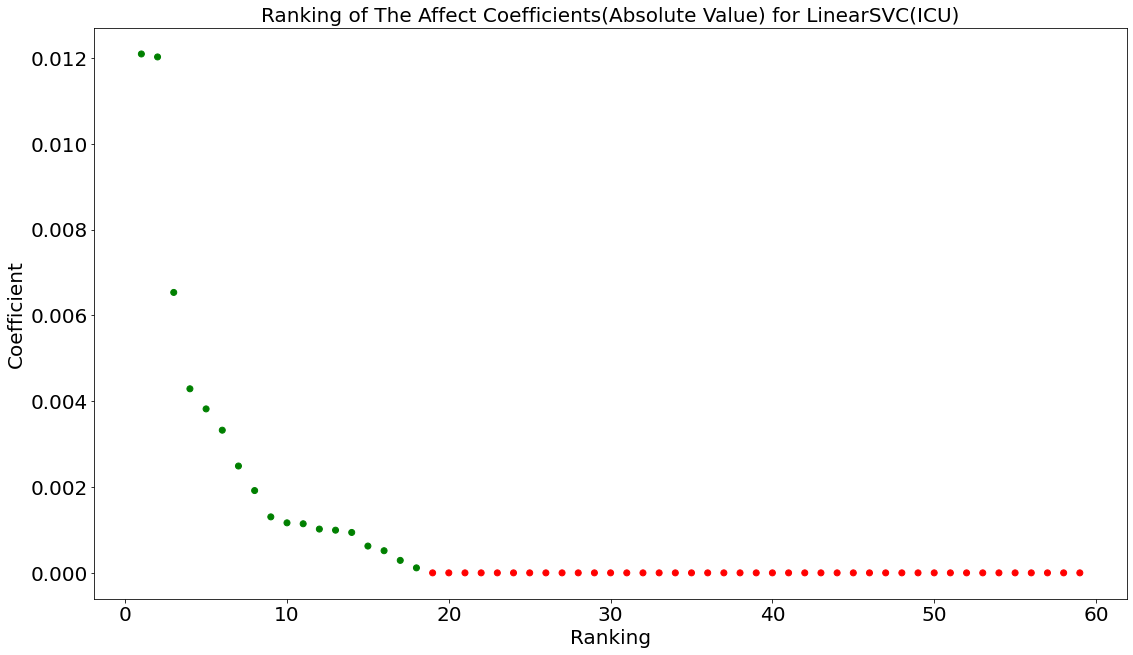

The ranking of the affect coefficients(absolute value) for LinearSVC(ICU) is:
1. Tm169Di(PPARg: Unknown): 0.01209607377611364
2. Er170Di(CD3: T Cell): 0.012026916555148887
3. Ce140Di(Ce140Di: Unknown): 0.0065370962271740045
4. Gd158Di(CD33: Dendritic Cell/ Stem Cell/ Macrophage/ Granulocyte): 0.004291012311329205
5. Pd104Di(Null: Unknown): 0.003822056343188242
6. Yb174Di(HLADR: Unknown): 0.0033257438787553
7. Pd105Di(Null: Unknown): 0.00249062782219204
8. Er168Di(CD206: Dendritic Cell/ Macrophage/ Endothelial Cell/  Epithelial Cell): 0.0019184383094840985
9. Nd148Di(CD16: T Cell/ Dendritic Cell/ NK Cell/ Macrophage/ Granulocyte): 0.0013050102395076458
10. Pd106Di(Null: Unknown): 0.0011661264444355445
11. Pd108Di(Null: Unknown): 0.0011445173713708066
12. Sm147Di(Gata6: Unknown): 0.0010206364557168786
13. Gd157Di(Null: Unknown): 0.000994957479106479
14. Ho165Di(CD116: Dendritic Cell/ Macrophage/ Granulocyte): 0.0009419072423950288
15. Ir193Di(DNA: Unknown): 0.0006246176686701274
16. Nd15

In [13]:
# LinearSVC(ICU)
svc_dict = {}
name_icu = []
coef = []
for i in range(0, cell_names.shape[0]): 
    svc_dict[cell_names[i]] = abs(svc.coef_[0][i])
affect_coef = sorted(svc_dict.items(), key = lambda kv:(kv[1], kv[0]), reverse = True)
for i in range(0, len(affect_coef)):
    if (affect_coef[i][1] != 0):
        name_icu.append(affect_coef[i][0] + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")")
        coef.append(affect_coef[i][1])
    else:
        name_icu.append(affect_coef[i][0] + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")" + "(0 coef)")
        coef.append(affect_coef[i][1])

# Plot the Ranking
x_label = np.arange(1, 60, 1)
color = []
for i in range(0, len(coef)):
    if (coef[i] != 0):
        color.append('green')
    else:
        color.append('red')
fig, axs = plt.subplots(1, sharex=True, sharey=False)
fig.set_size_inches(18.5, 10.5)
axs.scatter(x_label, coef, color = color)
plt.title("Ranking of The Affect Coefficients(Absolute Value) for LinearSVC(ICU)", fontsize = 20)
plt.ylabel('Coefficient', size = 20)
plt.xlabel('Ranking', size = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

# List detailed numbers and cell names
print("The ranking of the affect coefficients(absolute value) for LinearSVC(ICU) is:")
zero_position = 0
for i in range(0, len(affect_coef)):
    if (affect_coef[i][1] != 0):
        print(str(i + 1) + ". " + str(affect_coef[i][0]) + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")" + ": " + str(affect_coef[i][1]))
    else:
        if (affect_coef[i - 1][1] != 0):
            zero_position = i + 1
            print(str(i + 1) + ". " + str(affect_coef[i][0]) + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")" + ": " + str(affect_coef[i][1]))
        else:
            print(str(zero_position) + ". " + str(affect_coef[i][0]) + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")" + ": " + str(affect_coef[i][1]))

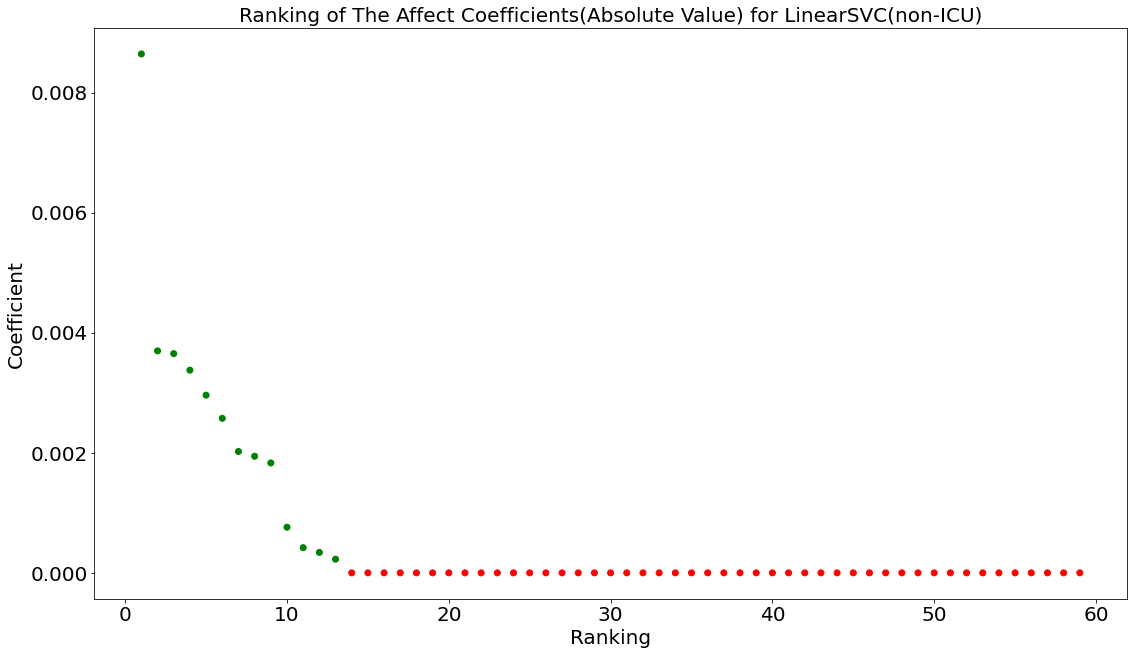

The ranking of the affect coefficients(absolute value) for LinearSVC(non-ICU) is:
1. Yb174Di(HLADR: Unknown): 0.008646770445728393
2. Pd105Di(Null: Unknown): 0.0036989899358736327
3. Eu151Di(CD123: Dendritic Cell/ Stem Cell/ Granulocyte/ ): 0.0036528900435690353
4. Pd106Di(Null: Unknown): 0.0033778613259501447
5. Gd158Di(CD33: Dendritic Cell/ Stem Cell/ Macrophage/ Granulocyte): 0.0029612717506297703
6. Er166Di(CD24: B Cell/ Granulocyte/ Epithelial Cell): 0.0025749386633228274
7. Yb172Di(CD11b: T Cell/ B Cell/ Dendritic Cell/ NK Cell/ Macrophage/ Granulocyte): 0.0020221779926498395
8. Pd102Di(Null: Unknown): 0.0019436902143098282
9. Pd108Di(Null: Unknown): 0.0018319406363482382
10. Gd157Di(Null: Unknown): 0.0007604969509727022
11. Er170Di(CD3: T Cell): 0.0004193982521650905
12. Ir193Di(DNA: Unknown): 0.00034084718466432303
13. Ce140Di(Ce140Di: Unknown): 0.0002280266794012157
14. Yb176Di(CD56: T Cell/ NK Cell): 0.0
14. Yb173Di(Yb173Di: Unknown): 0.0
14. Yb171Di(CD68: T Cell/ B Cell/ Den

In [17]:
# LinearSVC(non-ICU)
svc_dict = {}
name_non_icu = []
coef = []
for i in range(0, cell_names.shape[0]): 
    svc_dict[cell_names[i]] = abs(svc.coef_[1][i])
affect_coef = sorted(svc_dict.items(), key = lambda kv:(kv[1], kv[0]), reverse = True)
for i in range(0, len(affect_coef)):
    if (affect_coef[i][1] != 0):
        name_non_icu.append(affect_coef[i][0] + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")")
        coef.append(affect_coef[i][1])
    else:
        name_non_icu.append(affect_coef[i][0] + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")" + "(0 coef)")
        coef.append(affect_coef[i][1])

# Plot the Ranking
x_label = np.arange(1, 60, 1)
color = []
for i in range(0, len(coef)):
    if (coef[i] != 0):
        color.append('green')
    else:
        color.append('red')
fig, axs = plt.subplots(1, sharex=True, sharey=False)
fig.set_size_inches(18.5, 10.5)
axs.scatter(x_label, coef, color = color)
plt.title("Ranking of The Affect Coefficients(Absolute Value) for LinearSVC(non-ICU)", fontsize = 20)
plt.ylabel('Coefficient', size = 20)
plt.xlabel('Ranking', size = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

# List detailed numbers and cell names
print("The ranking of the affect coefficients(absolute value) for LinearSVC(non-ICU) is:")
zero_position = 0
for i in range(0, len(affect_coef)):
    if (affect_coef[i][1] != 0):
        print(str(i + 1) + ". " + str(affect_coef[i][0]) + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")" + ": " + str(affect_coef[i][1]))
    else:
        if (affect_coef[i - 1][1] != 0):
            zero_position = i + 1
            print(str(i + 1) + ". " + str(affect_coef[i][0]) + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")" + ": " + str(affect_coef[i][1]))
        else:
            print(str(zero_position) + ". " + str(affect_coef[i][0]) + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")" + ": " + str(affect_coef[i][1]))

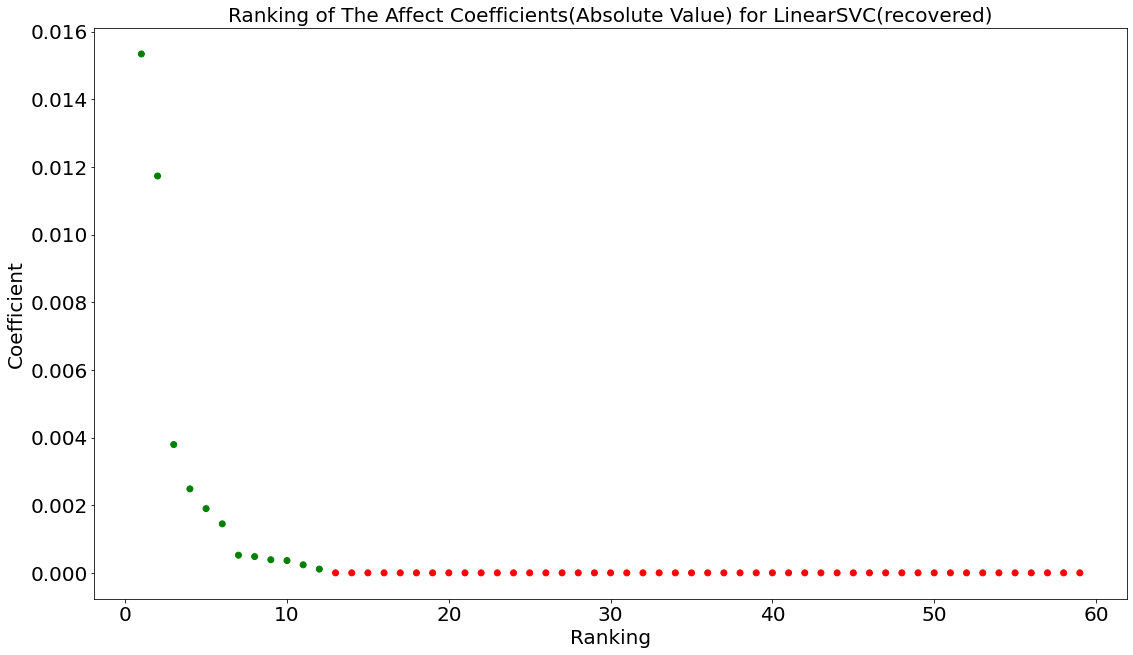

The ranking of the affect coefficients(absolute value) for LinearSVC(recovered) is:
1. Er170Di(CD3: T Cell): 0.01534044739691785
2. Tm169Di(PPARg: Unknown): 0.01173329250533198
3. Nd150Di(Nd150Di: Unknown): 0.003793410008326369
4. Nd148Di(CD16: T Cell/ Dendritic Cell/ NK Cell/ Macrophage/ Granulocyte): 0.002483354693824266
5. Sm147Di(Gata6: Unknown): 0.001899751402695128
6. Pd104Di(Null: Unknown): 0.0014488284891967316
7. Ir191Di(DNA: Unknown): 0.0005224570053881003
8. Ce140Di(Ce140Di: Unknown): 0.00048223518973331344
9. Pd105Di(Null: Unknown): 0.000387284022589996
10. Ir193Di(DNA: Unknown): 0.000363968194668147
11. Bi209Di(Null: Unknown): 0.00023838016174108104
12. Dy162Di(CD11c: T Cell/ B Cell/ Dendritic Cell/ NK Cell/ Macrophage/ Granulocyte): 0.00011103846158850089
13. Yb176Di(CD56: T Cell/ NK Cell): 0.0
13. Yb174Di(HLADR: Unknown): 0.0
13. Yb173Di(Yb173Di: Unknown): 0.0
13. Yb172Di(CD11b: T Cell/ B Cell/ Dendritic Cell/ NK Cell/ Macrophage/ Granulocyte): 0.0
13. Yb171Di(CD68: T Ce

In [18]:
# LinearSVC(recovered)
svc_dict = {}
name_recovered = []
coef = []
for i in range(0, cell_names.shape[0]): 
    svc_dict[cell_names[i]] = abs(svc.coef_[2][i])
affect_coef = sorted(svc_dict.items(), key = lambda kv:(kv[1], kv[0]), reverse = True)
for i in range(0, len(affect_coef)):
    if (affect_coef[i][1] != 0):
        name_recovered.append(affect_coef[i][0] + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")")
        coef.append(affect_coef[i][1])
    else:
        name_recovered.append(affect_coef[i][0] + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")" + "(0 coef)")
        coef.append(affect_coef[i][1])

# Plot the Ranking
x_label = np.arange(1, 60, 1)
color = []
for i in range(0, len(coef)):
    if (coef[i] != 0):
        color.append('green')
    else:
        color.append('red')
fig, axs = plt.subplots(1, sharex=True, sharey=False)
fig.set_size_inches(18.5, 10.5)
axs.scatter(x_label, coef, color = color)
plt.title("Ranking of The Affect Coefficients(Absolute Value) for LinearSVC(recovered)", fontsize = 20)
plt.ylabel('Coefficient', size = 20)
plt.xlabel('Ranking', size = 20)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.show()

# List detailed numbers and cell names
print("The ranking of the affect coefficients(absolute value) for LinearSVC(recovered) is:")
zero_position = 0
for i in range(0, len(affect_coef)):
    if (affect_coef[i][1] != 0):
        print(str(i + 1) + ". " + str(affect_coef[i][0]) + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")" + ": " + str(affect_coef[i][1]))
    else:
        if (affect_coef[i - 1][1] != 0):
            zero_position = i + 1
            print(str(i + 1) + ". " + str(affect_coef[i][0]) + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")" + ": " + str(affect_coef[i][1]))
        else:
            print(str(zero_position) + ". " + str(affect_coef[i][0]) + "(" + marker_cell_dict[affect_coef[i][0]] + ": " + CD_marker_to_cell[marker_cell_dict[affect_coef[i][0]]] + ")" + ": " + str(affect_coef[i][1]))

In [19]:
fig = go.Figure(data=[go.Table(
    header=dict(values=['Rank', 'LASSO', 'LinearSVC(ICU)', 'LinearSVC(non-ICU)', 'LinearSVC(recovered)'],
                fill_color='paleturquoise',
                align='center'),
    cells=dict(values=[x_label, name, name_icu, name_non_icu, name_recovered],
               fill_color='lavender',
               align='center'))
])

fig.show()

#### Save the table above

In [20]:
result = []
result.append(["Rank", "LASSO", "LinearSVC(ICU)", "LinearSVC(non-ICU)", "LinearSVC(recovered)"])
for i in range(0, len(x_label)):
    step_result = []
    step_result.append(x_label[i])
    step_result.append(name[i])
    step_result.append(name_icu[i])
    step_result.append(name_non_icu[i])
    step_result.append(name_recovered[i])
    result.append(step_result) 
np.savetxt('D:\\COMP 495\\COVID-19\\COVID-19 project_Brodinlab\\Influence factor comparison(ICU VS non-ICU VS recovered).csv', result, delimiter=",", newline = "\n", fmt="%s")

#### Calculate the correctness under different n_neighbors under each experiment(no feature selection + LASSO + LinearSVC)

In [51]:
skf = model_selection.StratifiedKFold(n_splits=6, shuffle=True, random_state=None)
knn_scores = []
knn_scores_lasso = []
knn_scores_lsvc = []
for train_index, test_index in skf.split(database, label):
    # no feature selection data
    knn_score = []
    database_train, database_test = database[train_index], database[test_index]
    
    # LASSO feature selection data
    knn_score_lasso = []
    database_train_lasso, database_test_lasso = model_lasso.transform(database[train_index]), model_lasso.transform(database[test_index])
    
    # LinearSVC feature selection data
    knn_score_lsvc = []
    database_train_lsvc, database_test_lsvc = model_svc.transform(database[train_index]), model_svc.transform(database[test_index])
    
    label_train, label_test = label[train_index], label[test_index]
    
    for n_neighbors in range(2, len(train_index)):
        
        knn = neighbors.KNeighborsClassifier(n_neighbors)
        total_score = len(label_test)
        
        score = 0
        knn.fit(database_train, label_train)
        for i in range(0, len(test_index)):
            result = knn.predict([database_test[i],])
            if (result[0] == label_test[i]):
                score = score + 1  
        knn_score.append(score / total_score)
        
        score_lasso = 0
        knn.fit(database_train_lasso, label_train)
        for i in range(0, len(test_index)):
            result = knn.predict([database_test_lasso[i],])
            if (result[0] == label_test[i]):
                score_lasso = score_lasso + 1  
        knn_score_lasso.append(score_lasso / total_score)
        
        score_lsvc = 0
        knn.fit(database_train_lsvc, label_train)
        for i in range(0, len(test_index)):
            result = knn.predict([database_test_lsvc[i],])
            if (result[0] == label_test[i]):
                score_lsvc = score_lsvc + 1  
        knn_score_lsvc.append(score_lsvc / total_score)
        
    knn_scores.append(knn_score)
    knn_scores_lasso.append(knn_score_lasso)
    knn_scores_lsvc.append(knn_score_lsvc)

#### Calculate the average correctness of the six experiments for each n_neighbors(no feature selection)

In [52]:
average_scores = []

for j in range(0, len(knn_scores[0])):
    score = []
    for i in range(0, 6):
        score.append(knn_scores[i][j])
    average_score = np.mean(score)
    average_scores.append(average_score)
    
score = []
for i in range(3, 6):
    score.append(knn_scores[i][-1])
average_score = np.mean(score)
average_scores.append(average_score)


#### Calculate the average correctness of the six experiments for each n_neighbors(LASSO)

In [53]:
average_scores_lasso = []

for j in range(0, len(knn_scores_lasso[0])):
    score_lasso = []
    for i in range(0, 6):
        score_lasso.append(knn_scores_lasso[i][j])
    average_score_lasso = np.mean(score_lasso)
    average_scores_lasso.append(average_score_lasso)
    
score_lasso = []
for i in range(3, 6):
    score_lasso.append(knn_scores_lasso[i][-1])
average_score_lasso = np.mean(score_lasso)
average_scores_lasso.append(average_score_lasso)

#### Calculate the average correctness of the six experiments for each n_neighbors(LinearSVC)

In [54]:
average_scores_lsvc = []

for j in range(0, len(knn_scores_lsvc[0])):
    score_lsvc = []
    for i in range(0, 6):
        score_lsvc.append(knn_scores_lsvc[i][j])
    average_score_lsvc = np.mean(score_lsvc)
    average_scores_lsvc.append(average_score_lsvc)
    
score_lsvc = []
for i in range(3, 6):
    score_lsvc.append(knn_scores_lsvc[i][-1])
average_score_lsvc = np.mean(score_lsvc)
average_scores_lsvc.append(average_score_lsvc)

#### Pick out the opimal n_neighbors in terms of average correctness

In [55]:
print(average_scores)
n_neighbors = np.argmax(average_scores) + 2
print("KNN(no feature selection) prefers n_neighbors = " + str(n_neighbors))

[0.7772727272727272, 0.8106060606060607, 0.7803030303030304, 0.7636363636363636, 0.7318181818181818, 0.7318181818181818, 0.7651515151515151, 0.7318181818181818, 0.6681818181818183, 0.703030303030303, 0.6848484848484849, 0.6863636363636364, 0.7015151515151515, 0.7015151515151515, 0.6848484848484849, 0.6696969696969698, 0.7166666666666667, 0.7000000000000001, 0.653030303030303, 0.6696969696969696, 0.6848484848484849, 0.6848484848484849, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0

In [56]:
print(average_scores_lasso)
n_neighbors_lasso = np.argmax(average_scores_lasso) + 2
print("KNN(LASSO) prefers n_neighbors = " + str(n_neighbors_lasso))

[0.7772727272727272, 0.8106060606060607, 0.7803030303030304, 0.7484848484848484, 0.7151515151515152, 0.7621212121212122, 0.7636363636363637, 0.7166666666666667, 0.6681818181818183, 0.7348484848484849, 0.6848484848484849, 0.7181818181818181, 0.7181818181818181, 0.7015151515151515, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7000000000000001, 0.7015151515151515, 0.7015151515151515, 0.6848484848484849, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516,

In [57]:
print(average_scores_lsvc)
n_neighbors_lsvc = np.argmax(average_scores_lsvc) + 2
print("KNN(LinearSVC) prefers n_neighbors = " + str(n_neighbors_lsvc))

[0.7803030303030303, 0.7787878787878788, 0.7651515151515151, 0.7621212121212121, 0.7318181818181818, 0.7000000000000001, 0.7166666666666667, 0.7166666666666667, 0.6515151515151515, 0.6863636363636364, 0.7000000000000001, 0.7015151515151515, 0.7166666666666667, 0.715151515151515, 0.7166666666666667, 0.6848484848484849, 0.7166666666666667, 0.7015151515151515, 0.6696969696969696, 0.6363636363636362, 0.6848484848484849, 0.6348484848484849, 0.6515151515151516, 0.6363636363636364, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 0.6515151515151516, 

#### KNN correctness on the test set using the optimized n_neighbors(no feature selection)

In [58]:
# create the model
knn = neighbors.KNeighborsClassifier(n_neighbors)

# fit the model
knn.fit(database, label)

total_score = ICU_patients_datas_validation.shape[0] + non_ICU_patients_datas_validation.shape[0] + recovered_patients_datas_validation.shape[0]
knn_score = 0

for i in range(0, ICU_patients_datas_validation.shape[0]):
    result = knn.predict([ICU_patients_datas_validation[i],])
    print("ICU patient: is determined to be a " + result[0] + " patient")
    if (result[0] == 'ICU'):
        knn_score = knn_score + 1

for i in range(0, non_ICU_patients_datas_validation.shape[0]):
    result = knn.predict([non_ICU_patients_datas_validation[i],])
    print("non_ICU patient: is determined to be a " + result[0] + " patient")
    if (result[0] == 'non-ICU'):
        knn_score = knn_score + 1

for i in range(0, recovered_patients_datas_validation.shape[0]):
    result = knn.predict([recovered_patients_datas_validation[i],])
    print("recovered patient: is determined to be a " + result[0] + " patient")
    if (result[0] == 'recovered'):
        knn_score = knn_score + 1

score = round(100 * knn_score / total_score, 2)

print()
print("KNN score(without demension reduction): " + str(score))

ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a recovered patient
ICU patient: is determined to be a recovered patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
non_ICU patient: is determined to be a ICU patient
non_ICU patient: is determined to be a ICU patient
recovered patient: is determined to be a recovered patient
recovered patient: is determined to be a recovered patient
recovered patient: is determined to be a non-ICU patient
recovered patient: is determined to be a ICU patient

KNN score(without demension reduction): 64.71


#### KNN correctness on the test set using the optimized n_neighbors(LASSO)

In [59]:
# create the model
knn = neighbors.KNeighborsClassifier(n_neighbors_lasso)

# fit the model
knn.fit(model_lasso.transform(database), label)

total_score = ICU_patients_datas_validation.shape[0] + non_ICU_patients_datas_validation.shape[0] + recovered_patients_datas_validation.shape[0]
knn_score_lasso = 0

for i in range(0, ICU_patients_datas_validation.shape[0]):
    result = knn.predict([model_lasso.transform(ICU_patients_datas_validation)[i],])
    print("ICU patient: is determined to be a " + result[0] + " patient")
    if (result[0] == 'ICU'):
        knn_score_lasso = knn_score_lasso + 1

for i in range(0, non_ICU_patients_datas_validation.shape[0]):
    result = knn.predict([model_lasso.transform(non_ICU_patients_datas_validation)[i],])
    print("non_ICU patient: is determined to be a " + result[0] + " patient")
    if (result[0] == 'non-ICU'):
        knn_score_lasso = knn_score_lasso + 1

for i in range(0, recovered_patients_datas_validation.shape[0]):
    result = knn.predict([model_lasso.transform(recovered_patients_datas_validation)[i],])
    print("recovered patient: is determined to be a " + result[0] + " patient")
    if (result[0] == 'recovered'):
        knn_score_lasso = knn_score_lasso + 1

score_lasso = round(100 * knn_score_lasso / total_score, 2)

print()
print("KNN score(LASSO): " + str(score_lasso))

ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a recovered patient
ICU patient: is determined to be a recovered patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
non_ICU patient: is determined to be a ICU patient
non_ICU patient: is determined to be a ICU patient
recovered patient: is determined to be a recovered patient
recovered patient: is determined to be a recovered patient
recovered patient: is determined to be a non-ICU patient
recovered patient: is determined to be a ICU patient

KNN score(LASSO): 64.71


#### KNN correctness on the test set using the optimized n_neighbors(LinearSVC)

In [60]:
# create the model
knn = neighbors.KNeighborsClassifier(n_neighbors_lsvc)

# fit the model
knn.fit(model_svc.transform(database), label)

total_score = ICU_patients_datas_validation.shape[0] + non_ICU_patients_datas_validation.shape[0] + recovered_patients_datas_validation.shape[0]
knn_score_lsvc = 0

for i in range(0, ICU_patients_datas_validation.shape[0]):
    result = knn.predict([model_svc.transform(ICU_patients_datas_validation)[i],])
    print("ICU patient: is determined to be a " + result[0] + " patient")
    if (result[0] == 'ICU'):
        knn_score_lsvc = knn_score_lsvc + 1

for i in range(0, non_ICU_patients_datas_validation.shape[0]):
    result = knn.predict([model_svc.transform(non_ICU_patients_datas_validation)[i],])
    print("non_ICU patient: is determined to be a " + result[0] + " patient")
    if (result[0] == 'non-ICU'):
        knn_score_lsvc = knn_score_lsvc + 1

for i in range(0, recovered_patients_datas_validation.shape[0]):
    result = knn.predict([model_svc.transform(recovered_patients_datas_validation)[i],])
    print("recovered patient: is determined to be a " + result[0] + " patient")
    if (result[0] == 'recovered'):
        knn_score_lsvc = knn_score_lsvc + 1

score_lsvc = round(100 * knn_score_lsvc / total_score, 2)

print()
print("KNN score(LinearSVC): " + str(score_lsvc))

ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a recovered patient
ICU patient: is determined to be a non-ICU patient
ICU patient: is determined to be a non-ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
ICU patient: is determined to be a ICU patient
non_ICU patient: is determined to be a ICU patient
non_ICU patient: is determined to be a ICU patient
recovered patient: is determined to be a recovered patient
recovered patient: is determined to be a recovered patient
recovered patient: is determined to be a non-ICU patient
recovered patient: is determined to be a ICU patient

KNN score(LinearSVC): 58.82
